# Dynamic threshold

Work in progress.

In this notebook I experimented with the dynamic threshold (__dth__) model using the threshold dynamics described in the Adaptive LIF (ALIF) neuron model from the paper: https://arxiv.org/abs/2103.12593.

Two new hyperparameters are introduced: 
  
*   $τ_t$ as the time constant controlling the threshold dynamics
    * Set to be the same as $\tau$ in the experiments
*   $β$ controlling the size of adaptation of the threshold
    * Set to 1 in the experiments

Note that in addition to the threshold dynamics, the ALIF model in the paper also subtracts the threshold from the membrane potential instead of setting it to resting potential after a spike. Models using this method are denoted as __subtraction models__ below and has __sub__ in their tags.

Experiments done:
*   Original classification (__oc__), oc_sub, dth and dth_sub model in 20ms and 2ms


Results: 
*   For 20ms case, the methods have similar performance
    * Oc_sub model sometimes performs worse than 20% acc, which is not seen in other models
*   In 2ms case:
    * Subtraction models lead to better performance
    * Dth is slightly worse than oc (similar median, slightly larger variation)
    * Dth_sub performs better than oc_sub





Further work:

*   Hyperparameter search to optimize $τ_t$ and $\beta$
*   Optimize $τ_t$ and $\beta$ as trainable parameters



In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.nn.functional as F

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

# Change this to your own path

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/Shareddrives/SNN_sound_localization/Results_stage2/oc_vs_dth')

# import os
# os.chdir('/root/research/SR/Results_stage2')

import pandas as pd
import seaborn as sns

from ast import literal_eval

Mounted at /content/drive


In [2]:
!ls

dth_sub_2ms_taut_acc_2ms.png  dth_sub_2ms_taut_err.png	oc_vs_dth_err_2ms.png
dth_sub_2ms_taut_acc_2ms.svg  dth_sub_2ms_taut_err.svg	oc_vs_dth_err_2ms.svg
dth_sub_2ms_taut_acc.png      oc_vs_dth_acc_2ms.png	oc_vs_dth_err.png
dth_sub_2ms_taut_acc.svg      oc_vs_dth_acc_2ms.svg	oc_vs_dth_err.svg
dth_sub_2ms_taut_err_2ms.png  oc_vs_dth_acc.png		opt_tau_t
dth_sub_2ms_taut_err_2ms.svg  oc_vs_dth_acc.svg		saved_results


 # Original Code From the Starting Notebook

## Sound localization stimuli

The following function creates a set of stimuli that can be used for training or testing. We have two ears (0 and 1), and ear 1 will get a version of the signal delayed by an IPD we can write as $\alpha$ in equations (``ipd`` in code). The basic signal is a sine wave as in the previous notebook, made positive, so $(1/2)(1+\sin(\theta)$. In addition, for each ear there will be $N_a$ neurons per ear (``anf_per_ear`` because these are auditory nerve fibres). Each neuron generates Poisson spikes at a certain firing rate, and these Poisson spike trains are independent. In addition, since it is hard to train delays, we seed it with uniformly distributed delays from a minimum of 0 to a maximum of $\pi/2$ in each ear, so that the differences between the two ears can cover the range of possible IPDs ($-\pi/2$ to $\pi/2$). We do this directly by adding a phase delay to each neuron. So for ear $i\in\{0,1\}$ and neuron $j$ at time $t$ the angle $\theta=2\pi f t+i\alpha+j\pi/2N_a$. Finally, we generate Poisson spike trains with a rate $R_\mathrm{max}((1/2)(1+\sin(\theta)))^k$. $R_\mathrm{max}$ (``rate_max``) is the maximum instantaneous firing rate, and $k$ (``envelope_power``) is a constant that sharpens the envelope. The higher $R_\mathrm{max}$ and $k$ the easier the problem (try it out on the cell below to see why).

Here's a picture of the architecture for the stimuli:

![Stimuli architecture](diagrams/arch-stimuli.png)

The functions below return two arrays ``ipd`` and ``spikes``. ``ipd`` is an array of length ``num_samples`` that gives the true IPD, and ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, duration_steps, 2*anf_per_ear)``, where ``duration_steps`` is the number of time steps there are in the stimulus.

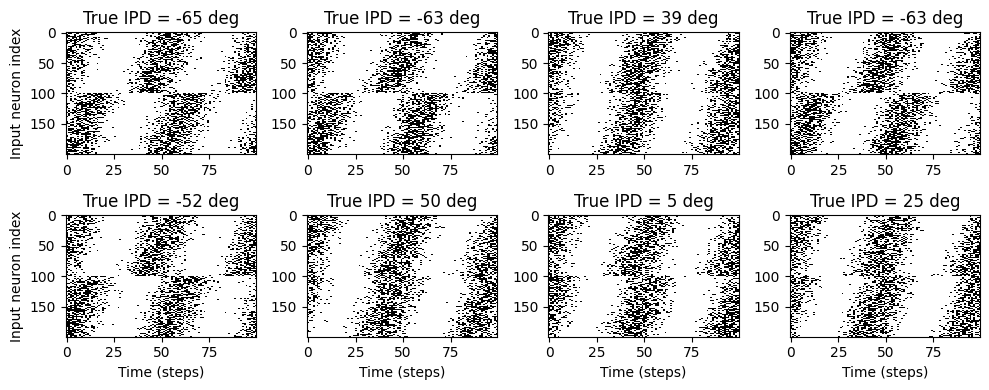

In [ ]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot a few just to show how it looks
ipd, spikes = random_ipd_input_signal(8)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

Now the aim is to take these input spikes and infer the IPD. We can do this either by discretising and using a classification approach, or with a regression approach. For the moment, let's try it with a classification approach.

## Classification approach

We discretise the IPD range of $[-\pi/2, \pi/2]$ into $N_c$ (``num_classes``) equal width segments. Replace angle $\phi$ with the integer part (floor) of $(\phi+\pi/2)N_c/\pi$. We also convert the arrays into PyTorch tensors for later use. The algorithm will now guess the index $i$ of the segment, converting that to the midpoint of the segment $\phi_i=a+(i+1/2)(b-a)/N_c$ when needed.

The algorithm will work by outputting a length $N_c$ vector $y$ and the index of the maximum value of y will be the guess as to the class (1-hot encoding), i.e. $i_\mathrm{est}=\mathrm{argmax}_i y_i$. We will perform the training with a softmax and negative loss likelihood loss, which is a standard approach in machine learning.

In [ ]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


## Membrane only (no spiking neurons)

Before we get to spiking, we're going to warm up with a non-spiking network that shows some of the features of the full model but without any coincidence detection, it can't do the task. We basically create a neuron model that has everything except spiking, so the membrane potential dynamics are there and it takes spikes as input. The neuron model we'll use is just the LIF model we've already seen. We'll use a time constant $\tau$ of 20 ms, and we pre-calculate a constant $\alpha=\exp(-dt/\tau)$ so that updating the membrane potential $v$ is just multiplying by $\alpha$ (as we saw in the first notebook). We store the input spikes in a vector $s$ of 0s and 1s for each time step, and multiply by the weight matrix $W$ to get the input, i.e. $v\leftarrow \alpha v+Ws$.

We initialise the weight matrix $W$ uniformly with bounds proportionate to the inverse square root of the number of inputs (fairly standard, and works here).

The output of this will be a vector of $N_c$ (``num_classes``) membrane potential traces. We sum these traces over time and use this as the output vector (the largest one will be our prediction of the class and therefore the IPD).

![Membrane only architecture](diagrams/arch-membrane.png)

In [ ]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    # Note that the requires_grad=True argument tells PyTorch that we'll be computing gradients with
    # respect to the values in this tensor and thereby learning those values. If you want PyTorch to
    # learn some gradients, make sure it has this on.
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

# Run the simulation
def membrane_only(input_spikes, W, tau=20*ms):
    # Input has shape (batch_size, duration_steps, input_size)
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b, but faster
    h = torch.einsum("abc,cd->abd", (input_spikes, W))
    # precalculate multiplication factor
    alpha = np.exp(-dt/tau)
    # Update membrane and spikes one time step at a time
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

### Training

We train this by dividing the input data into batches and computing gradients across batches. In this notebook, batch and data size is small so that it can be run on a laptop in a couple of minutes, but normally you'd use larger batches and more data. Let's start with the data.

In [ ]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

Now we run the training. We generate the training data, initialise the weight matrix, set the training parameters, and run for a few epochs, printing the training loss as we go. We use the all-powerful Adam optimiser, softmax and negative log likelihood loss.

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=6.30739
Epoch 2: loss=3.12158
Epoch 3: loss=2.90743
Epoch 4: loss=2.64192
Epoch 5: loss=2.45578
Epoch 6: loss=2.40789
Epoch 7: loss=2.31922
Epoch 8: loss=2.16295
Epoch 9: loss=2.20243
Epoch 10: loss=2.05727


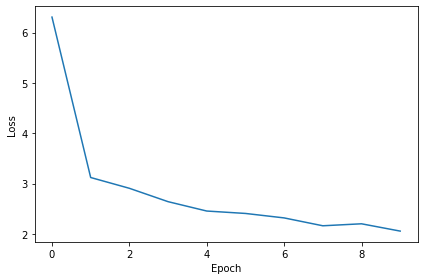

In [ ]:
# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrix
W = init_weight_matrix()

# Optimiser and loss function
optimizer = torch.optim.Adam([W], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss() # negative log likelihood loss

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        # Run network
        output = membrane_only(x_local, W)
        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01  # Sum time dimension
        loss = loss_fn(log_softmax_fn(m), y_local)
        local_loss.append(loss.item())
        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

### Analysis of results

Now we compute the training and test accuracy, and plot histograms and confusion matrices to understand the errors it's making.

Chance accuracy level: 8.3%

Train classifier accuracy: 36.3%
Train absolute error: 16.1 deg

Test classifier accuracy: 9.4%
Test absolute error: 57.2 deg


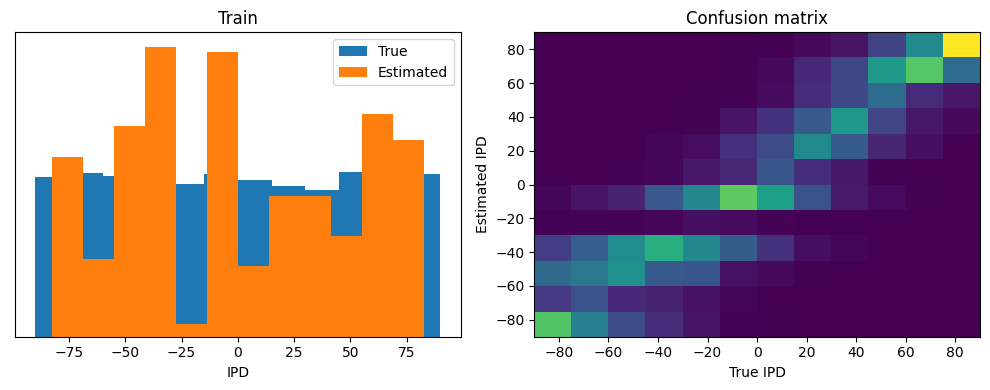

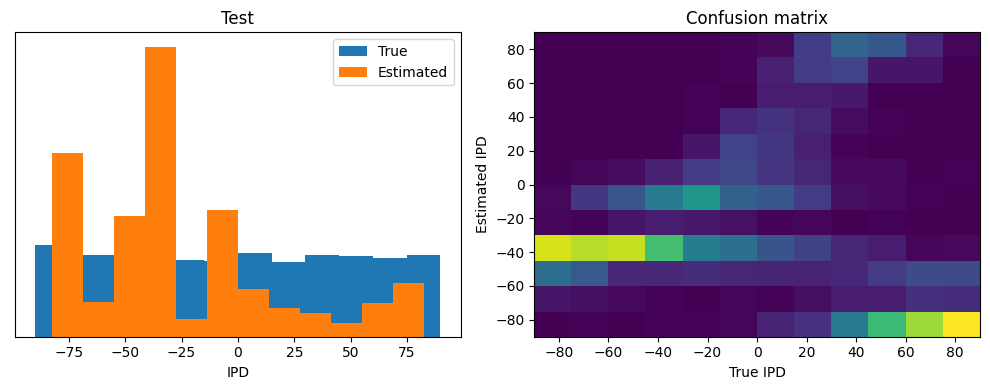

In [ ]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
    plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: membrane_only(x, W)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

This poor performance isn't surprising because this network is not actually doing any coincidence detection, just a weighted sum of input spikes.

## Spiking model

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.

![Full architecture](diagrams/arch-full.png)

### Surrogate gradient descent

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.

In [ ]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

### Updated model

The code for the updated model is very similar to the membrane only layer. First, for initialisation we now need two weight matrices, $W_1$ from the input to the hidden layer, and $W_2$ from the hidden layer to the output layer. Second, we run two passes of the loop that you saw above for the membrane only model.

The first pass computes the output spikes of the hidden layer. The second pass computes the output layer and is exactly the same as before except using the spikes from the hidden layer instead of the input layer.

For the first pass, we modify the function in two ways.

Firstly, we compute the spikes with the line ``s = spike_fn(v-1)``. In the forward pass this just computes the Heaviside function of $v-1$, i.e. returns 1 if $v>1$, otherwise 0, which is the spike threshold function for the LIF neuron. In the backwards pass, it returns a gradient of the smoothed version of the Heaviside function.

The other line we change is the membrane potential update line. Now, we multiply by $1-s$ where ($s=1$ if there was a spike in the previous time step, otherwise $s=0$), so that the membrane potential is reset to 0 after a spike (but in a differentiable way rather than just setting it to 0).

In [ ]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

### Training and analysing

We train it as before, except that we modify the functions to take the two weight matrices into account.

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.07820
Epoch 2: loss=1.38058
Epoch 3: loss=1.08499
Epoch 4: loss=0.92522
Epoch 5: loss=0.85050
Epoch 6: loss=0.77508
Epoch 7: loss=0.69778
Epoch 8: loss=0.64543
Epoch 9: loss=0.64462
Epoch 10: loss=0.61308


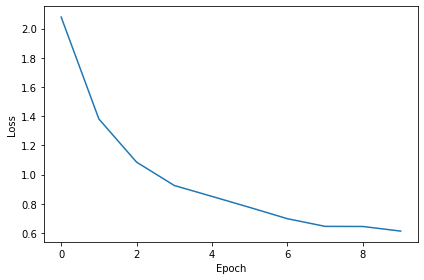

In [ ]:
# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        # Run network
        output = snn(x_local, W1, W2)
        # Compute cross entropy loss
        m = torch.mean(output, 1)  # Mean across time dimension
        loss = loss_fn(log_softmax_fn(m), y_local)
        local_loss.append(loss.item())
        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

You might already see that the loss functions are lower than before, so maybe performance is better? Let's see.

Chance accuracy level: 8.3%

Train classifier accuracy: 78.2%
Train absolute error: 5.2 deg

Test classifier accuracy: 60.7%
Test absolute error: 7.8 deg


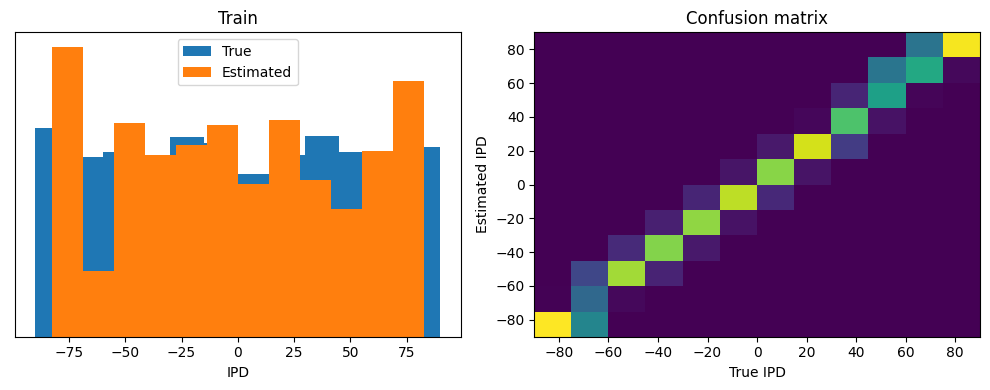

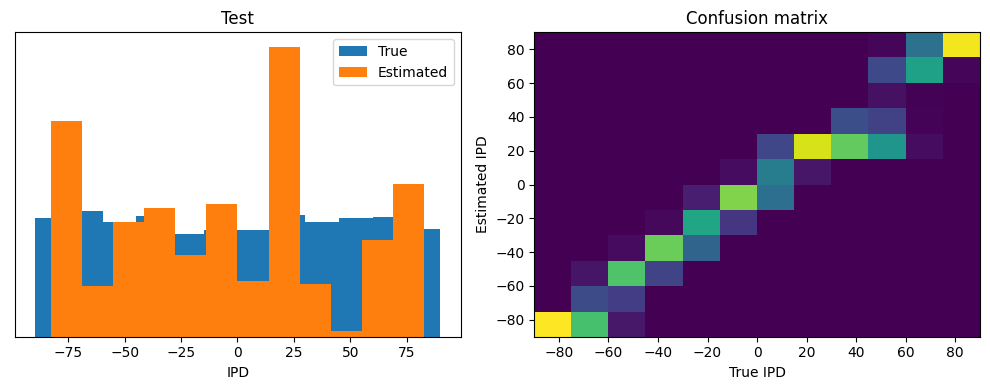

In [ ]:
# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

Yes! Performance is much better and now the confusion matrices look more like what you'd expect too. Let's take a look at the weight matrices.

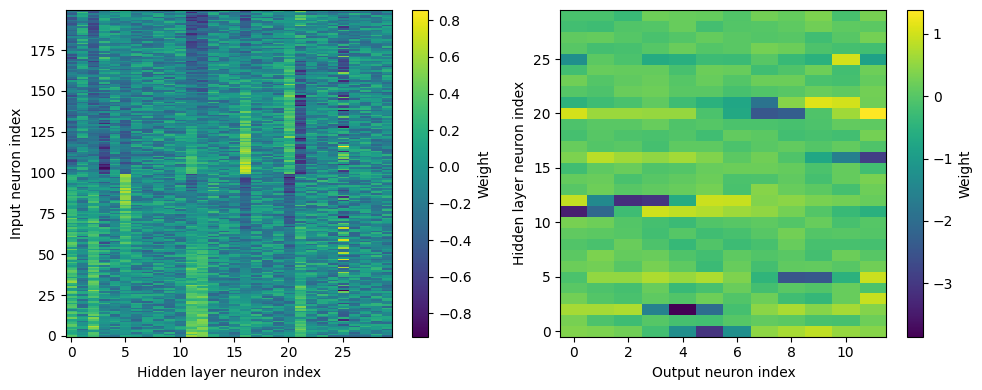

In [ ]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

Hmm, hard to interpret.


Here's what I've got so far...

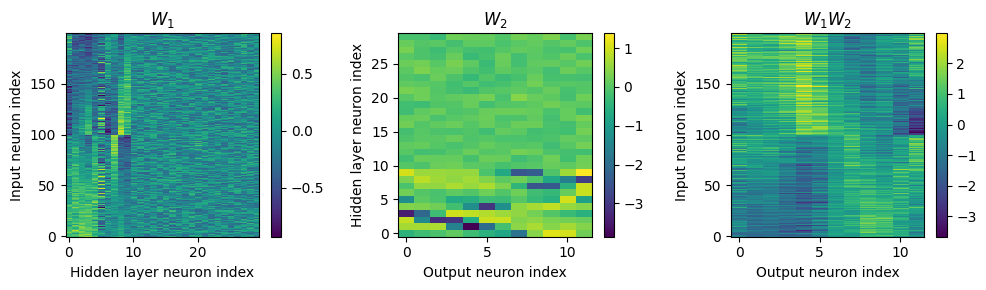

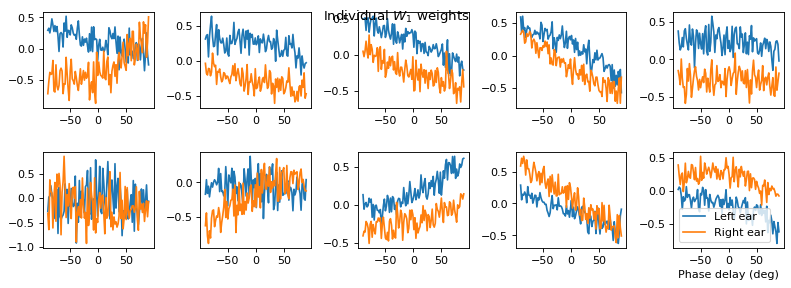

In [ ]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

# Experiments

## Code necessary to run experiments

Note: I copied some cells from previous parts that are necessary for experiments here so that I don't have to look for and run them from the part above again and again.

Necessary constants

In [3]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

Generating input signal

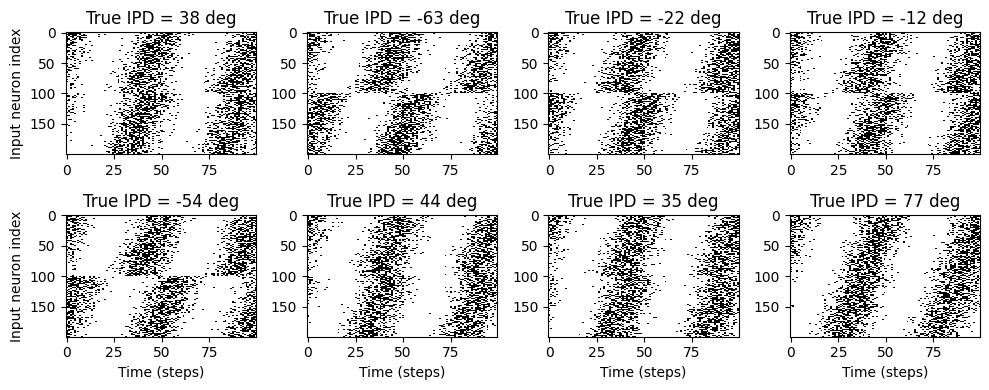

In [4]:
# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot a few just to show how it looks
ipd, spikes = random_ipd_input_signal(8)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

In [5]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

Surrogate Gradient Descent

In [6]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        if torch.any(torch.isnan(grad)):
            import ipdb;ipdb.set_trace()
        return grad

spike_fn  = SurrGradSpike.apply

Discretise input for classification

In [7]:
def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Function to analyse classification results

In [8]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

#     plt.figure(figsize=(10, 4), dpi=100)
#     plt.subplot(121)
#     plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
#     plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
#     plt.xlabel("IPD")
#     plt.yticks([])
#     plt.legend(loc='best')
#     plt.title(label)
#     plt.subplot(122)
#     confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
#     plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
#     plt.xlabel('True IPD')
#     plt.ylabel('Estimated IPD')
#     plt.title('Confusion matrix')
#     plt.tight_layout()

    return 100*np.mean(accs), np.mean(abs_errors_deg)

In [9]:
def analyse_reg(ipds, spikes, label, run):
    ipd_true = []
    ipd_est = []
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        output = run(x_local)
        am = torch.mean(output, 1).flatten()
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(am.detach().cpu().numpy())
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    return np.mean(abs_errors_deg)

## Models

### Original

In [10]:
def snn_init(shape):  
    W = nn.Parameter(torch.empty((shape), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)

    return W

class snn_layer(nn.Module):
    def __init__(self, in_size, out_size, spike=True, tau=20*ms, reset=True):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.spike = spike
        self.tau = tau
        self.W = snn_init((in_size, out_size))
        self.reset = reset

    def forward(self, input_spikes, fn=spike_fn):
        batch_size = input_spikes.shape[0]
        v = torch.zeros((batch_size, self.out_size), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.out_size), device=device, dtype=dtype)
        h = torch.einsum("abc,cd->abd", (input_spikes, self.W))
        alpha = np.exp(-dt/self.tau)

        if self.spike: # spiking neuron
            s_rec = [s]
            v_rec = [v]
            for t in range(duration_steps - 1):
                if self.reset: # reset membrane potential to rest
                    new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
                else: # subtract threshold from membrane potential
                    new_v = (alpha*v + h[:, t, :]) - s
                s = fn(v-1) # threshold of 1
                v = new_v
                s_rec.append(s)
                v_rec.append(v)
            s_rec = torch.stack(s_rec, dim=1)
            v_rec = torch.stack(v_rec, dim=1)
            return s_rec#, v_rec
        else: # membrane only
            v_rec = [v]
            for t in range(duration_steps - 1):
                v = alpha*v + h[:, t, :]
                v_rec.append(v)
            v_rec = torch.stack(v_rec, dim=1)
            return v_rec

In [11]:
# classes at 15 degree increments
num_classes = 180//15
num_hidden = 30
print(f'Number of classes = {num_classes}')

class snn_original(nn.Module):
    def __init__(self, num_hidden=num_hidden, tau=20*ms, reset=True):
        super().__init__()
        # import ipdb;ipdb.set_trace()
        self.layer1 = snn_layer(input_size, num_hidden, tau=tau, reset=reset)
        self.layer2 = snn_layer(num_hidden, num_classes, spike=False, tau=tau)
    def forward(self, input_spikes):
        s_rec = self.layer1(input_spikes)
        v_rec = self.layer2(s_rec)
        return v_rec

Number of classes = 12


### Dynamic threshold

In [ ]:
class snn_layer_dth(nn.Module):
    def __init__(self, in_size, out_size, spike=True, tau=20*ms, tau_t=20*ms, beta=1, reset=True):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.spike = spike
        self.tau = tau
        self.tau_t = tau_t
        self.W = snn_init((in_size, out_size))
        self.beta = beta
        self.reset = reset

    def forward(self, input_spikes, fn=spike_fn):
        batch_size = input_spikes.shape[0]
        v = torch.zeros((batch_size, self.out_size), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.out_size), device=device, dtype=dtype)
        vt = torch.zeros((batch_size, self.out_size), device=device, dtype=dtype)
        h = torch.einsum("abc,cd->abd", (input_spikes, self.W))
        alpha = np.exp(-dt/self.tau)
        rho = np.exp(-dt/self.tau_t)

        if self.spike: # spiking neuron
            s_rec = [s]
            v_rec = [v]
            vt_rec = [vt]
            for t in range(duration_steps - 1):
                if self.reset: # reset membrane potential to rest
                    new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
                else: # subtract threshold from membrane potential
                    new_v = (alpha*v + h[:, t, :]) - s*(vt+1)
                s = fn(v-(self.beta*vt+1)) # threshold of vt
                v = new_v
                vt = rho*vt + (1-rho)*s
                s_rec.append(s)
                v_rec.append(v)
                vt_rec.append(vt)
            s_rec = torch.stack(s_rec, dim=1)
            v_rec = torch.stack(v_rec, dim=1)
            vt_rec = torch.stack(vt_rec, dim=1)
            return s_rec#, v_rec, vt_rec
        else: # membrane only
            v_rec = [v]
            for t in range(duration_steps - 1):
                v = alpha*v + h[:, t, :]
                v_rec.append(v)
            v_rec = torch.stack(v_rec, dim=1)
            return v_rec

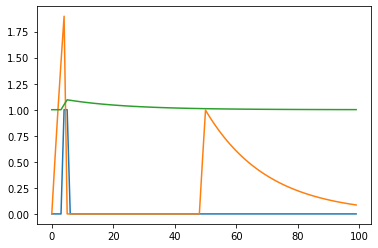

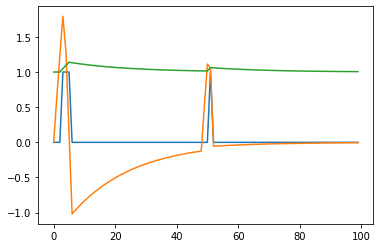

In [ ]:
test_layer = snn_layer_dth(1,1)
test_layer_2 = snn_layer_dth(1,1, reset=False)
test_input = torch.zeros((1, duration_steps, 1)).to(device)
test_input[0,0,0] = 1
test_input[0,1,0] = 1
test_input[0,2,0] = 1
test_input[0,3,0] = 1
test_input[0,48,0] = 1
test_input[0,49,0] = 1
s_rec, v_rec, vt_rec = test_layer(test_input)
plt.plot(s_rec[0, :, 0].cpu().detach().numpy())
plt.plot(v_rec[0, :, 0].cpu().detach().numpy())
plt.plot(vt_rec[0, :, 0].cpu().detach().numpy()+1)
plt.show()

s_rec, v_rec, vt_rec = test_layer_2(test_input)
plt.figure()
plt.plot(s_rec[0, :, 0].cpu().detach().numpy())
plt.plot(v_rec[0, :, 0].cpu().detach().numpy())
plt.plot(vt_rec[0, :, 0].cpu().detach().numpy()+1)
plt.show()

In [ ]:
# classes at 15 degree increments
num_classes = 180//15
num_hidden = 30
print(f'Number of classes = {num_classes}')

class snn_dth(nn.Module):
    def __init__(self, num_hidden=num_hidden, beta=1, tau=20*ms, tau_t=20*ms, reset=True):
        super().__init__()
        self.layer1 = snn_layer_dth(input_size, num_hidden, beta=beta, tau=tau, tau_t=tau_t, reset=reset)
        # In non-spiking case, tau_t, beta and reset are unused
        self.layer2 = snn_layer_dth(num_hidden, num_classes, spike=False, tau=tau) 
    def forward(self, input_spikes):
        s_rec = self.layer1(input_spikes)
        v_rec = self.layer2(s_rec)
        return v_rec

Number of classes = 12


## Helper funcs

In [ ]:
def train(name, model_type, model_args={}, num_iters=10, folder='saved_results'):
    # Training parameters
    nb_epochs = 10 # quick, it won't have converged
    lr = 0.01 # learning rate

    train_acc = []
    train_err = []
    test_acc = []
    test_err = []

    for i in range(num_iters):
        # Generate the training data
        ipds, spikes = random_ipd_input_signal(num_samples)

        # Initialise a weight matrices
        model = model_type(**model_args)

        # Optimiser and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        log_softmax_fn = nn.LogSoftmax(dim=1)
        loss_fn = nn.NLLLoss()

        print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

        loss_hist = []
        for e in range(nb_epochs):
            local_loss = []
            for x_local, y_local in data_generator(discretise(ipds), spikes):
                # Run network
                output = model(x_local)
                # Compute cross entropy loss
                m = torch.mean(output, 1)  # Mean across time dimension
                loss = loss_fn(log_softmax_fn(m), y_local)
                local_loss.append(loss.item())
                # Update gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss_hist.append(np.mean(local_loss))
            print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

        # Plot the loss function over time
        plt.plot(loss_hist)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()

        # Analyse
        print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
        run_func = lambda x: model(x)
        acc, err = analyse(ipds, spikes, 'Train', run=run_func)
        train_acc.append(acc)
        train_err.append(err)
        ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
        acc, err = analyse(ipds_test, spikes_test, 'Test', run=run_func)
        test_acc.append(acc)
        test_err.append(err)

    res_dict = {'train_acc': train_acc, 'test_acc': test_acc, 'train_err': train_err, 'test_err': test_err}
    np.save(f'{folder}/{name}.npy', res_dict)

In [ ]:
def plot_results(exp_tag, path='saved_results'):
    filenames = sorted(os.listdir(path))#, reverse=True)

    train_err = []
    test_err = []
    train_acc = []
    test_acc = []
    tags = []

    train_err_2ms = []
    test_err_2ms = []
    train_acc_2ms = []
    test_acc_2ms = []
    tags_2ms = []

    for filename in filenames:
        tag = filename[:-4]
        tags.append(tag)
        data = np.load(path +'/'+ filename, allow_pickle=True).item()
        train_acc.append(data['train_acc'])
        test_acc.append(data['test_acc'])
        train_err.append(data['train_err'])
        test_err.append(data['test_err'])
        if tag[-3:] == '2ms':
            train_acc_2ms.append(data['train_acc'])
            test_acc_2ms.append(data['test_acc'])
            train_err_2ms.append(data['train_err'])
            test_err_2ms.append(data['test_err'])
            tags_2ms.append(tag)

    acc = pd.DataFrame({'Tag':tags,'Train':train_acc,'Test':test_acc})
    err = pd.DataFrame({'Tag':tags,'Train':train_err,'Test':test_err})

    plt.figure()
    dd= pd.melt(acc, id_vars=['Tag'],value_vars=['Train','Test'], var_name='Type')
    dd = dd.explode('value')
    sns.boxplot(x='Tag',y='value',data=dd,hue='Type', showmeans=True, 
                meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"5"})
    plt.xticks(rotation=55)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Boxplot')
    plt.savefig(f'{exp_tag}_acc.svg')
    plt.savefig(f'{exp_tag}_acc.png')

    plt.figure()
    dd= pd.melt(err, id_vars=['Tag'],value_vars=['Train','Test'], var_name='Type')
    dd = dd.explode('value')
    sns.boxplot(x='Tag',y='value',data=dd,hue='Type', showmeans=True, 
                meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"5"})
    plt.xticks(rotation=55)
    plt.ylabel('Error')
    plt.title('Error Boxplot')
    plt.savefig(f'{exp_tag}_err.svg')
    plt.savefig(f'{exp_tag}_err.png')

    acc_2ms = pd.DataFrame({'Tag':tags_2ms,'Train':train_acc_2ms,'Test':test_acc_2ms})
    err_2ms = pd.DataFrame({'Tag':tags_2ms,'Train':train_err_2ms,'Test':test_err_2ms})

    plt.figure()
    dd= pd.melt(acc_2ms, id_vars=['Tag'],value_vars=['Train','Test'], var_name='Type')
    dd = dd.explode('value')
    sns.boxplot(x='Tag',y='value',data=dd,hue='Type', showmeans=True, 
                meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"5"})
    plt.xticks(rotation=55)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Boxplot')
    plt.savefig(f'{exp_tag}_acc_2ms.svg')
    plt.savefig(f'{exp_tag}_acc_2ms.png')

    plt.figure()
    dd= pd.melt(err_2ms, id_vars=['Tag'],value_vars=['Train','Test'], var_name='Type')
    dd = dd.explode('value')
    sns.boxplot(x='Tag',y='value',data=dd,hue='Type', showmeans=True, 
                meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"5"})
    plt.xticks(rotation=55)
    plt.ylabel('Error')
    plt.title('Error Boxplot')
    plt.savefig(f'{exp_tag}_err_2ms.svg')
    plt.savefig(f'{exp_tag}_err_2ms.png')

## Visualization Codes

In [12]:
def analyse_vis(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
    plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()

    return 100*np.mean(accs), np.mean(abs_errors_deg)

In [13]:
def vis_weights(W_list):
    w1 = W_list[0].detach().cpu().numpy()
    w2 = W_list[1].detach().cpu().numpy()

    # for each column of w1, compute the weighted mean and re-order according to that
    A = np.arange(w1.shape[0])[:, None]
    weighted_mean = np.mean((A*w1), axis=0)
    weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
    I = np.argsort(weighted_mean)
    w1 = w1[:, I]
    w2 = w2[I, :]

    # Plot the re-ordered weight matrices
    plt.figure(figsize=(10, 3), dpi=100)
    plt.subplot(131)
    plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
    plt.ylabel('Input neuron index')
    plt.xlabel('Hidden layer neuron index')
    plt.title('$W_1$')
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
    plt.ylabel('Hidden layer neuron index')
    plt.xlabel('Output neuron index')
    plt.title('$W_2$')
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
    plt.ylabel('Input neuron index')
    plt.xlabel('Output neuron index')
    plt.title('$W_1W_2$')
    plt.colorbar()
    plt.tight_layout()

    # Plot some sample weights for hidden neurons
    I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
    plt.figure(figsize=(10, 5), dpi=80)
    phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
    for i, j in list(enumerate(I_nz))[:15]:
        plt.subplot(3, 5, i+1)
        plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
        plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
    plt.suptitle("Individual $W_1$ weights")
    plt.legend(loc='best')
    plt.xlabel('Phase delay (deg)')
    plt.tight_layout()

In [14]:
def vis(model_type, model_args={}, tau_min=1e-15, train_tau=False, train_tau_dth=False):
    # Training parameters
    nb_epochs = 10 # quick, it won't have converged
    lr = 0.01 # learning rate

    # Generate the training data
    ipds, spikes = random_ipd_input_signal(num_samples)

    # Initialise a weight matrices
    model = model_type(**model_args)

    # Optimiser and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = model(x_local)
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension
            loss = loss_fn(log_softmax_fn(m), y_local)
            local_loss.append(loss.item())
            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    # Analyse
    print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
    run_func = lambda x: model(x)
    acc, err = analyse_vis(ipds, spikes, 'Train', run=run_func)
    ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
    acc, err = analyse_vis(ipds_test, spikes_test, 'Test', run=run_func)

    W_list = []
    for name, param in model.named_parameters():
        if 'W' in name:
            W_list.append(param)
    vis_weights(W_list)

## Results

In [ ]:
os.chdir('/root/research/SR/Results_stage2/oc_vs_dth')

### Original Classification

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.29399
Epoch 2: loss=1.64293
Epoch 3: loss=1.36252
Epoch 4: loss=1.18828
Epoch 5: loss=1.05866
Epoch 6: loss=0.96985
Epoch 7: loss=0.89438
Epoch 8: loss=0.85632
Epoch 9: loss=0.80889
Epoch 10: loss=0.78020
Chance accuracy level: 8.3%

Train classifier accuracy: 75.4%
Train absolute error: 5.3 deg

Test classifier accuracy: 57.1%
Test absolute error: 8.6 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.44382
Epoch 2: loss=1.58440
Epoch 3: loss=1.21662
Epoch 4: loss=1.00142
Epoch 5: loss=0.88721
Epoch 6: loss=0.79237
Epoch 7: loss=0.75874
Epoch 8: loss=0.69683
Epoch 9: loss=0.65904
Epoch 10: loss=0.66396
Chance accuracy level: 8.3%

Train classifier accuracy: 72.2%
Train absolute error: 5.6 deg

Test classifier accuracy: 31.7%
Test absolute error: 13.5 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.26814
Ep

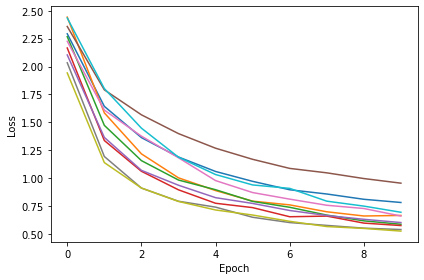

In [ ]:
train('oc', snn_original)

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.04960
Epoch 2: loss=1.44207
Epoch 3: loss=1.13225
Epoch 4: loss=0.95383
Epoch 5: loss=0.84058
Epoch 6: loss=0.75862
Epoch 7: loss=0.70281
Epoch 8: loss=0.65635
Epoch 9: loss=0.60964
Epoch 10: loss=0.57268
Chance accuracy level: 8.3%

Train classifier accuracy: 88.1%
Train absolute error: 4.2 deg

Test classifier accuracy: 84.7%
Test absolute error: 4.4 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.05547
Epoch 2: loss=1.44219
Epoch 3: loss=1.14589
Epoch 4: loss=0.95452
Epoch 5: loss=0.83343
Epoch 6: loss=0.73995
Epoch 7: loss=0.67879
Epoch 8: loss=0.61537
Epoch 9: loss=0.58839
Epoch 10: loss=0.54326
Chance accuracy level: 8.3%

Train classifier accuracy: 86.1%
Train absolute error: 4.4 deg

Test classifier accuracy: 83.3%
Test absolute error: 4.5 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.12791
Epo

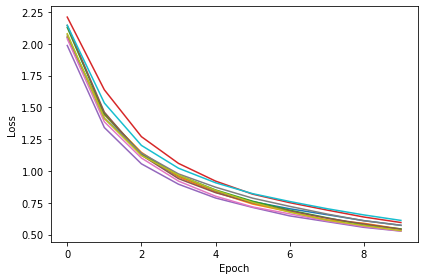

In [ ]:
train('oc_2ms', snn_original, model_args={'tau': 2*ms})

### Original Classification - subtract

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.47025
Epoch 2: loss=1.81706
Epoch 3: loss=1.63105
Epoch 4: loss=1.25126
Epoch 5: loss=0.77348
Epoch 6: loss=0.66629
Epoch 7: loss=0.59246
Epoch 8: loss=0.57472
Epoch 9: loss=0.54084
Epoch 10: loss=0.51424
Chance accuracy level: 8.3%

Train classifier accuracy: 82.1%
Train absolute error: 4.8 deg

Test classifier accuracy: 52.4%
Test absolute error: 29.8 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.50208
Epoch 2: loss=1.75753
Epoch 3: loss=1.47869
Epoch 4: loss=1.18494
Epoch 5: loss=0.90784
Epoch 6: loss=0.82117
Epoch 7: loss=0.76656
Epoch 8: loss=0.71347
Epoch 9: loss=0.69287
Epoch 10: loss=0.68017
Chance accuracy level: 8.3%

Train classifier accuracy: 76.5%
Train absolute error: 5.3 deg

Test classifier accuracy: 27.3%
Test absolute error: 34.0 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.31765
E

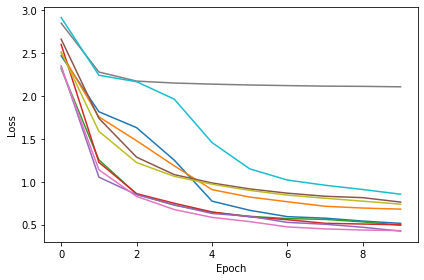

In [ ]:
train('oc_sub', snn_original, model_args={'reset': False})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.78486
Epoch 2: loss=1.03535
Epoch 3: loss=0.79667
Epoch 4: loss=0.67036
Epoch 5: loss=0.58049
Epoch 6: loss=0.52510
Epoch 7: loss=0.48208
Epoch 8: loss=0.43595
Epoch 9: loss=0.40858
Epoch 10: loss=0.38619
Chance accuracy level: 8.3%

Train classifier accuracy: 91.0%
Train absolute error: 4.0 deg

Test classifier accuracy: 85.4%
Test absolute error: 4.4 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.94218
Epoch 2: loss=1.14897
Epoch 3: loss=0.85292
Epoch 4: loss=0.68919
Epoch 5: loss=0.58526
Epoch 6: loss=0.52081
Epoch 7: loss=0.47587
Epoch 8: loss=0.43641
Epoch 9: loss=0.40289
Epoch 10: loss=0.38022
Chance accuracy level: 8.3%

Train classifier accuracy: 90.7%
Train absolute error: 4.0 deg

Test classifier accuracy: 85.6%
Test absolute error: 4.3 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.87030
Epo

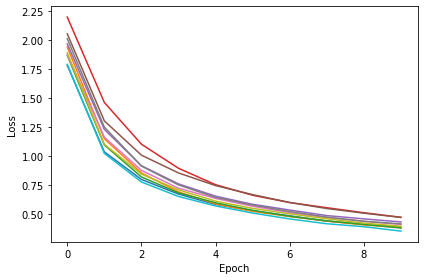

In [ ]:
train('oc_sub_2ms', snn_original, model_args={'tau': 2*ms, 'reset': False})

### Dynamic threshold

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.39133
Epoch 2: loss=1.45670
Epoch 3: loss=1.07446
Epoch 4: loss=0.90728
Epoch 5: loss=0.83008
Epoch 6: loss=0.76161
Epoch 7: loss=0.69750
Epoch 8: loss=0.64001
Epoch 9: loss=0.64878
Epoch 10: loss=0.59258
Chance accuracy level: 8.3%

Train classifier accuracy: 83.5%
Train absolute error: 4.6 deg

Test classifier accuracy: 60.9%
Test absolute error: 7.2 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.07759
Epoch 2: loss=1.32684
Epoch 3: loss=1.04997
Epoch 4: loss=0.88296
Epoch 5: loss=0.78559
Epoch 6: loss=0.73934
Epoch 7: loss=0.68654
Epoch 8: loss=0.62982
Epoch 9: loss=0.59600
Epoch 10: loss=0.56328
Chance accuracy level: 8.3%

Train classifier accuracy: 80.0%
Train absolute error: 4.9 deg

Test classifier accuracy: 74.0%
Test absolute error: 5.4 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.02584
Epo

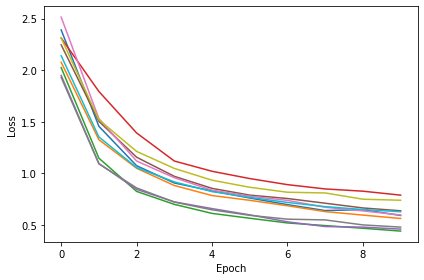

In [ ]:
train('dth', snn_dth)

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.09941
Epoch 2: loss=1.43305
Epoch 3: loss=1.12663
Epoch 4: loss=0.97061
Epoch 5: loss=0.84911
Epoch 6: loss=0.76286
Epoch 7: loss=0.69039
Epoch 8: loss=0.63255
Epoch 9: loss=0.58553
Epoch 10: loss=0.53907
Chance accuracy level: 8.3%

Train classifier accuracy: 88.6%
Train absolute error: 4.1 deg

Test classifier accuracy: 84.5%
Test absolute error: 4.3 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.08241
Epoch 2: loss=1.47013
Epoch 3: loss=1.15440
Epoch 4: loss=0.96530
Epoch 5: loss=0.84527
Epoch 6: loss=0.76650
Epoch 7: loss=0.69991
Epoch 8: loss=0.64465
Epoch 9: loss=0.60088
Epoch 10: loss=0.56100
Chance accuracy level: 8.3%

Train classifier accuracy: 87.8%
Train absolute error: 4.2 deg

Test classifier accuracy: 82.1%
Test absolute error: 4.6 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.17935
Epo

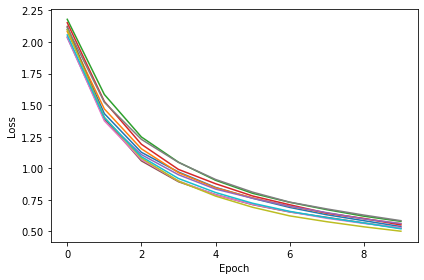

In [ ]:
train('dth_2ms', snn_dth, model_args={'tau': 2*ms, 'tau_t': 2*ms})

### Dynamic threshold - subtract

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.01497
Epoch 2: loss=1.02885
Epoch 3: loss=0.74560
Epoch 4: loss=0.64907
Epoch 5: loss=0.58754
Epoch 6: loss=0.51264
Epoch 7: loss=0.48571
Epoch 8: loss=0.43988
Epoch 9: loss=0.42755
Epoch 10: loss=0.38997
Chance accuracy level: 8.3%

Train classifier accuracy: 83.4%
Train absolute error: 4.6 deg

Test classifier accuracy: 46.6%
Test absolute error: 28.4 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.32352
Epoch 2: loss=1.50158
Epoch 3: loss=1.08665
Epoch 4: loss=0.87416
Epoch 5: loss=0.78831
Epoch 6: loss=0.69860
Epoch 7: loss=0.64685
Epoch 8: loss=0.63217
Epoch 9: loss=0.57983
Epoch 10: loss=0.57811
Chance accuracy level: 8.3%

Train classifier accuracy: 81.3%
Train absolute error: 4.8 deg

Test classifier accuracy: 56.2%
Test absolute error: 8.8 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.15313
Ep

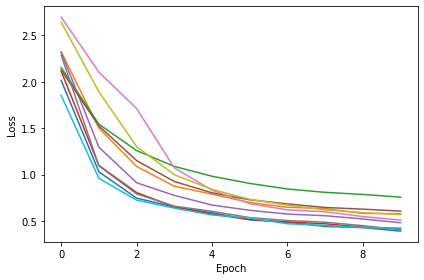

In [ ]:
train('dth_sub', snn_dth, model_args={'reset': False})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.03768
Epoch 2: loss=1.26005
Epoch 3: loss=0.97057
Epoch 4: loss=0.80038
Epoch 5: loss=0.69256
Epoch 6: loss=0.60906
Epoch 7: loss=0.55024
Epoch 8: loss=0.49859
Epoch 9: loss=0.46792
Epoch 10: loss=0.43114
Chance accuracy level: 8.3%

Train classifier accuracy: 92.1%
Train absolute error: 3.9 deg

Test classifier accuracy: 88.3%
Test absolute error: 4.2 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.08779
Epoch 2: loss=1.34759
Epoch 3: loss=1.01590
Epoch 4: loss=0.84471
Epoch 5: loss=0.73961
Epoch 6: loss=0.66465
Epoch 7: loss=0.59746
Epoch 8: loss=0.55482
Epoch 9: loss=0.50946
Epoch 10: loss=0.47566
Chance accuracy level: 8.3%

Train classifier accuracy: 89.9%
Train absolute error: 4.0 deg

Test classifier accuracy: 84.3%
Test absolute error: 4.3 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.00292
Epo

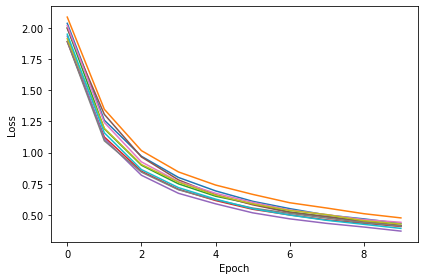

In [ ]:
train('dth_sub_2ms', snn_dth, model_args={'tau': 2*ms, 'tau_t': 2*ms, 'reset': False})

### Result figure

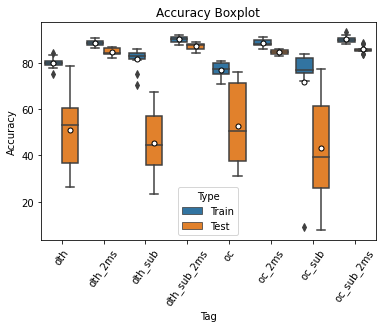

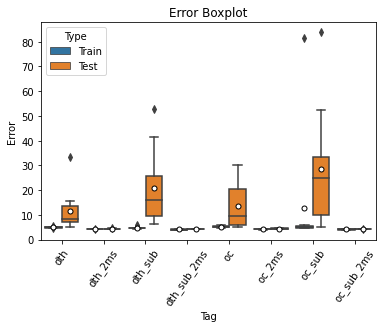

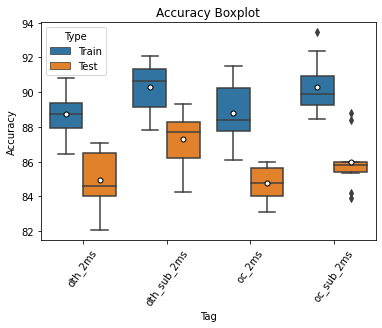

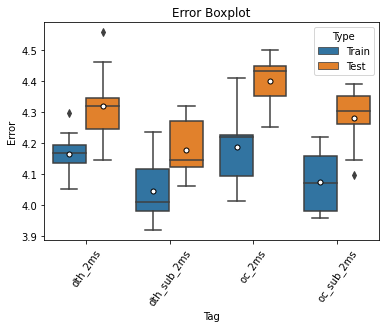

In [ ]:
plot_results('oc_vs_dth')

## Weight visualization

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.26091
Epoch 2: loss=1.38405
Epoch 3: loss=1.07995
Epoch 4: loss=0.92502
Epoch 5: loss=0.79919
Epoch 6: loss=0.74884
Epoch 7: loss=0.67400
Epoch 8: loss=0.63217
Epoch 9: loss=0.58088
Epoch 10: loss=0.56380
Chance accuracy level: 8.3%

Train classifier accuracy: 83.6%
Train absolute error: 4.6 deg

Test classifier accuracy: 16.6%
Test absolute error: 16.8 deg


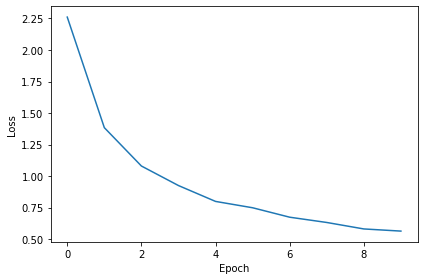

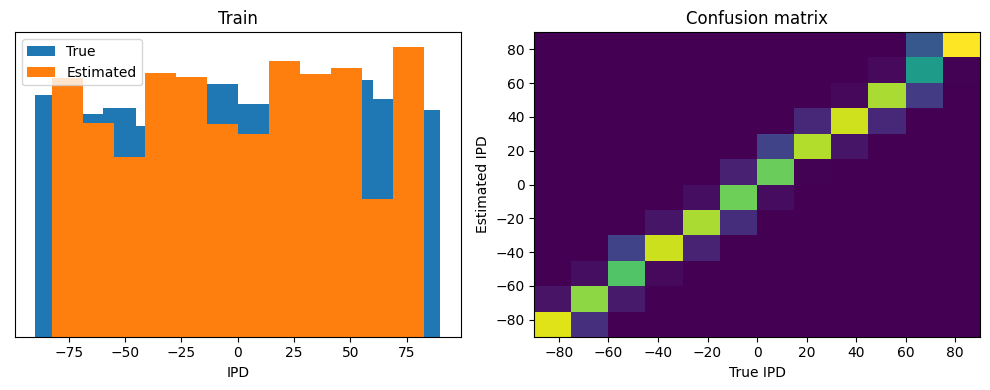

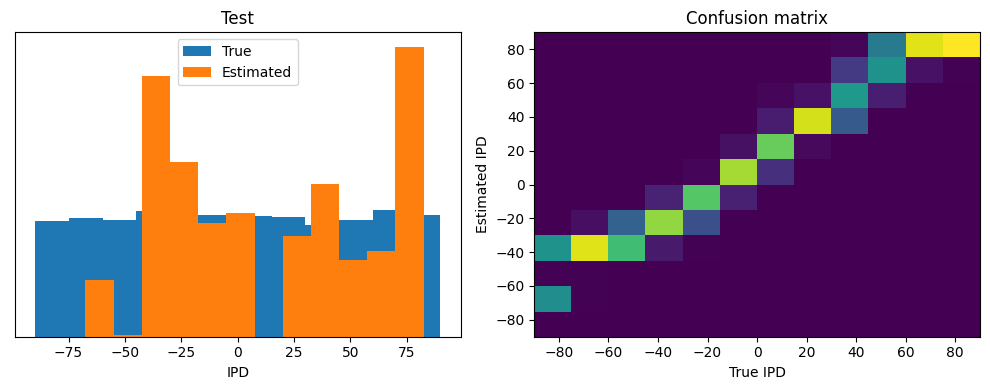

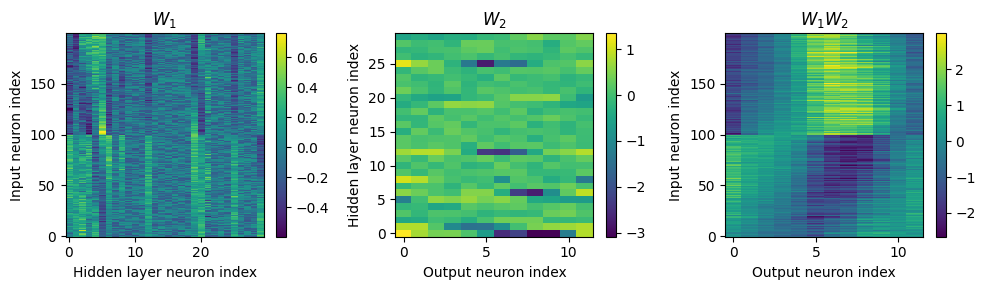

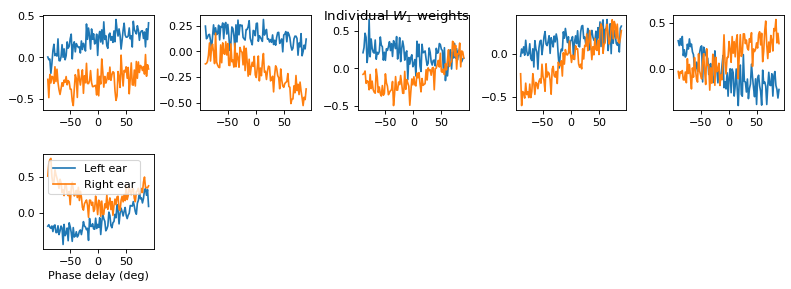

In [ ]:
vis(snn_original)

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.10730
Epoch 2: loss=1.41697
Epoch 3: loss=1.09829
Epoch 4: loss=0.93079
Epoch 5: loss=0.82170
Epoch 6: loss=0.74092
Epoch 7: loss=0.68574
Epoch 8: loss=0.63018
Epoch 9: loss=0.58419
Epoch 10: loss=0.55171
Chance accuracy level: 8.3%

Train classifier accuracy: 89.0%
Train absolute error: 4.1 deg

Test classifier accuracy: 84.5%
Test absolute error: 4.4 deg


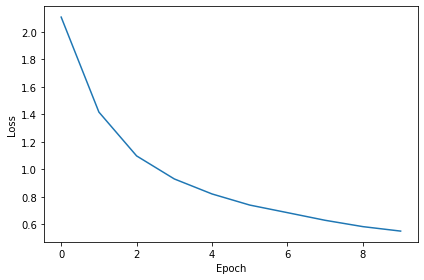

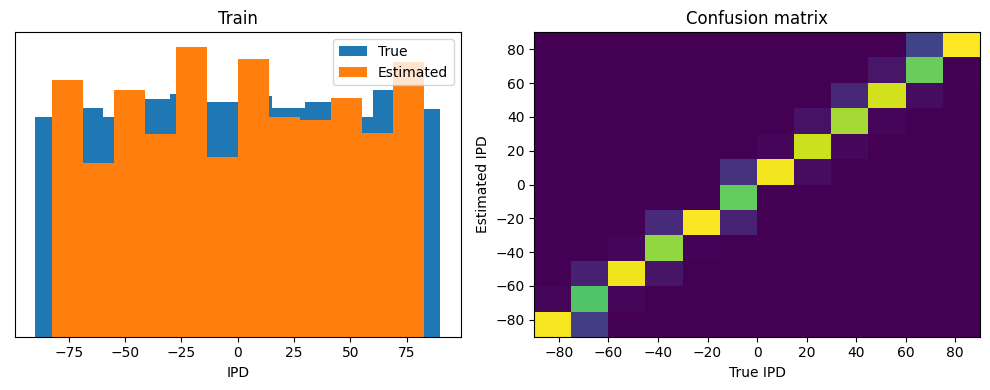

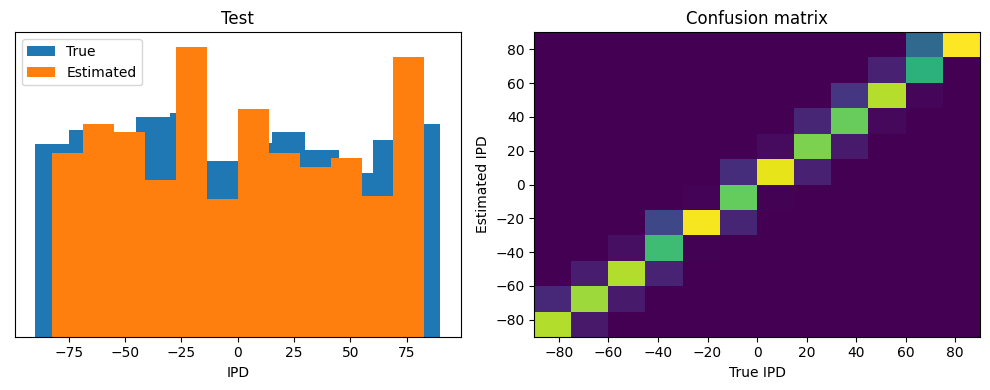

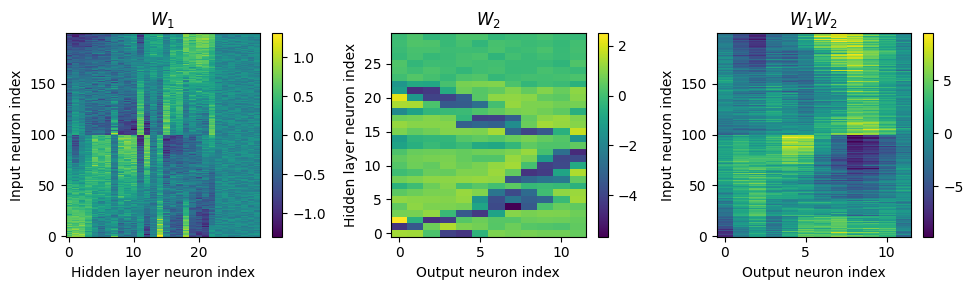

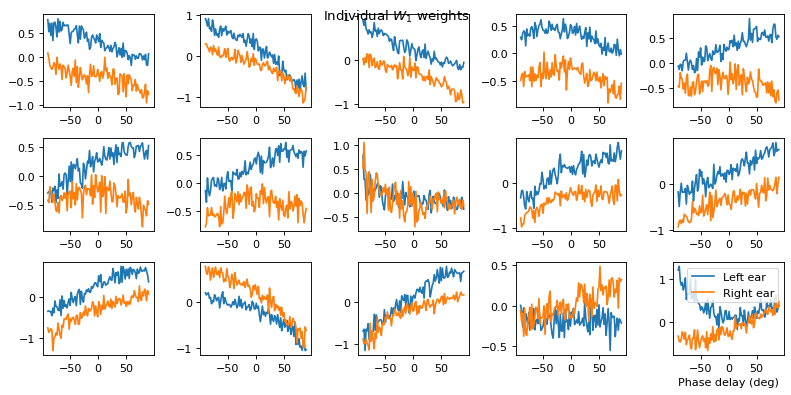

In [ ]:
vis(snn_original, model_args={'tau': 2*ms})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.38769
Epoch 2: loss=1.66242
Epoch 3: loss=1.33113
Epoch 4: loss=1.14439
Epoch 5: loss=1.03367
Epoch 6: loss=0.95739
Epoch 7: loss=0.88704
Epoch 8: loss=0.83954
Epoch 9: loss=0.79568
Epoch 10: loss=0.75907
Chance accuracy level: 8.3%

Train classifier accuracy: 73.0%
Train absolute error: 5.6 deg

Test classifier accuracy: 50.7%
Test absolute error: 9.4 deg


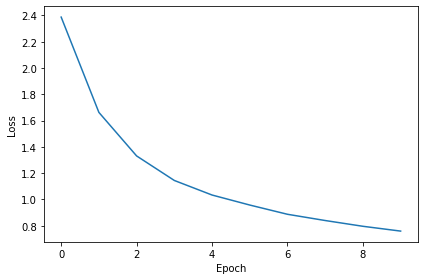

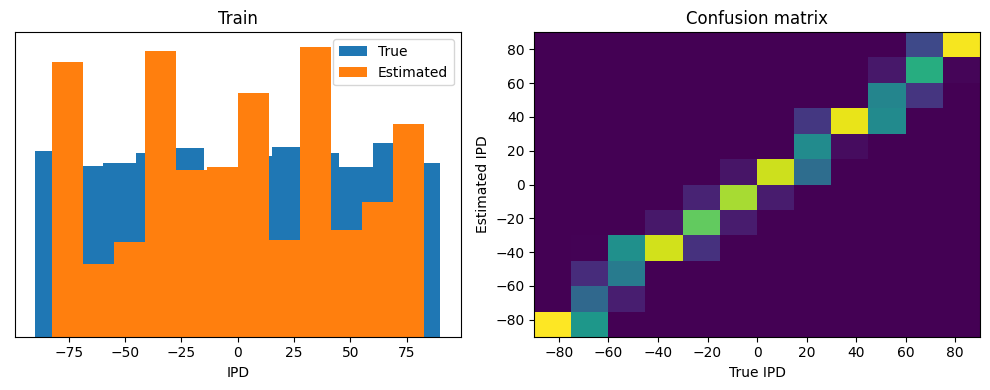

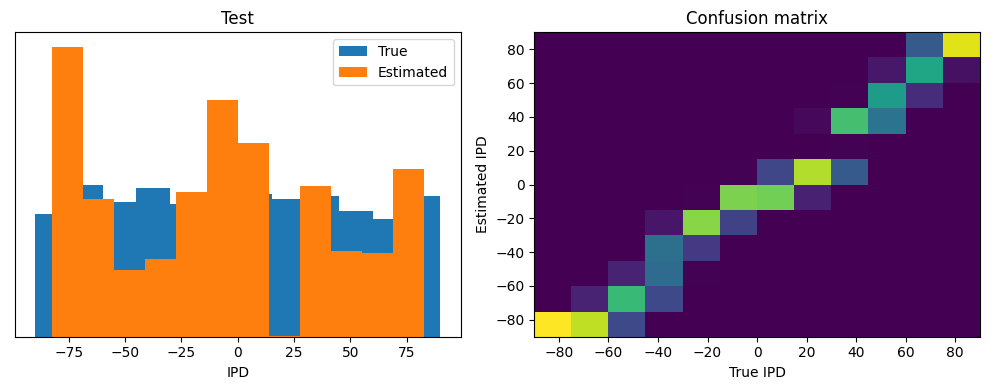

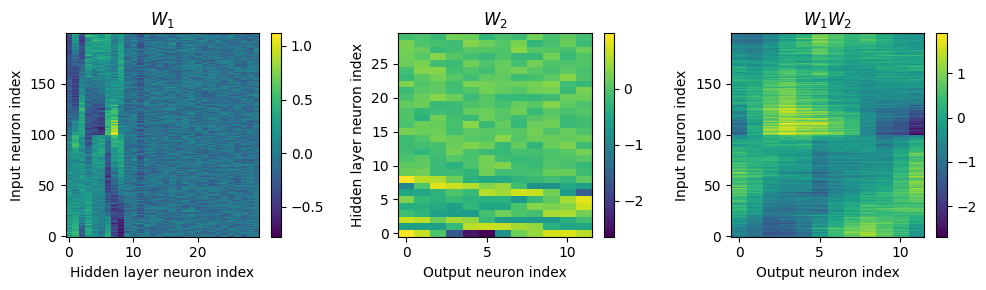

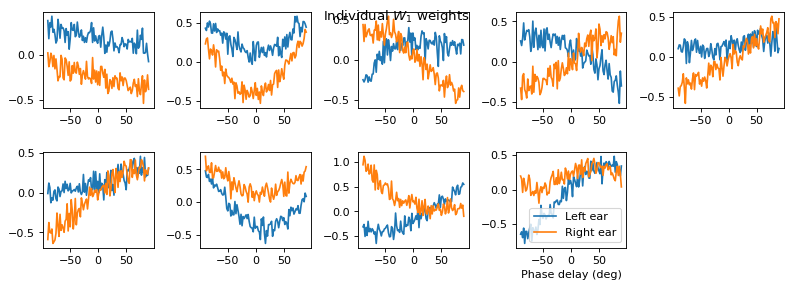

In [ ]:
vis(snn_dth)

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.07747
Epoch 2: loss=1.42444
Epoch 3: loss=1.11230
Epoch 4: loss=0.94418
Epoch 5: loss=0.83510
Epoch 6: loss=0.75168
Epoch 7: loss=0.68862
Epoch 8: loss=0.63339
Epoch 9: loss=0.59529
Epoch 10: loss=0.55417
Chance accuracy level: 8.3%

Train classifier accuracy: 89.4%
Train absolute error: 4.2 deg

Test classifier accuracy: 85.4%
Test absolute error: 4.4 deg


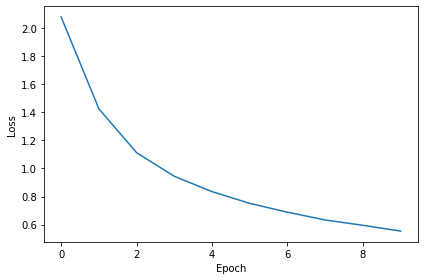

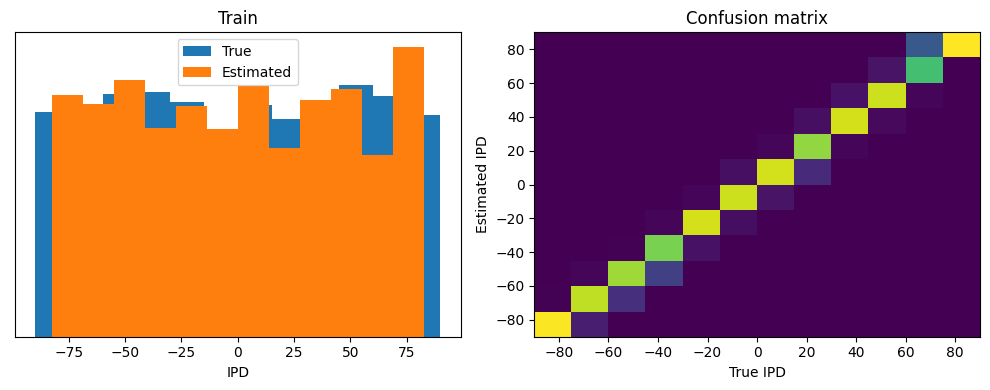

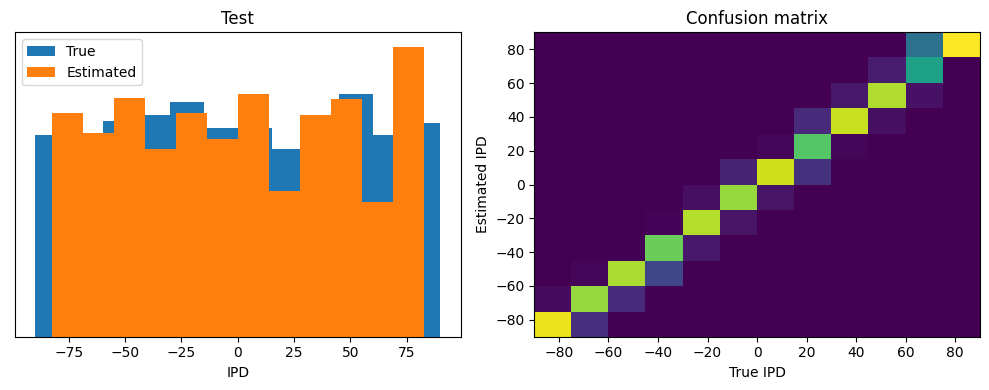

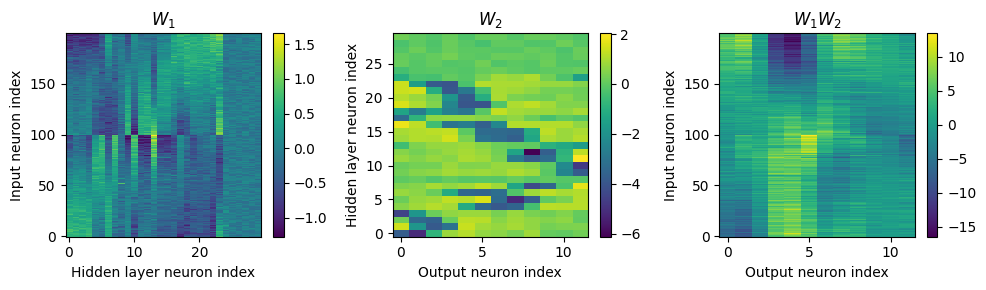

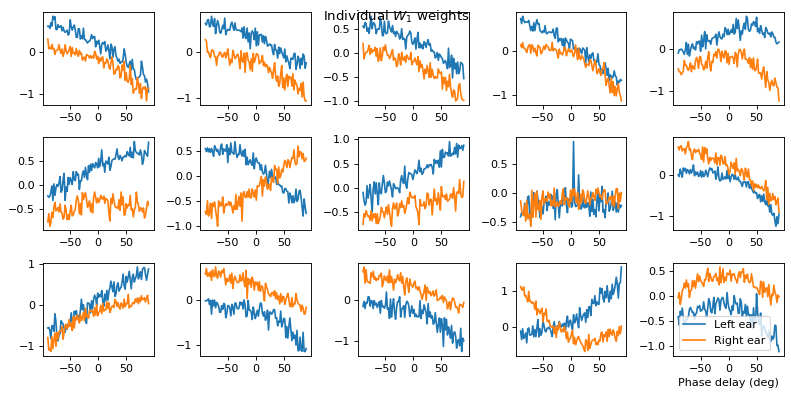

In [ ]:
vis(snn_dth, model_args={'tau': 2*ms, 'tau_t': 2*ms})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.40062
Epoch 2: loss=1.28023
Epoch 3: loss=0.89524
Epoch 4: loss=0.77486
Epoch 5: loss=0.70595
Epoch 6: loss=0.66234
Epoch 7: loss=0.62293
Epoch 8: loss=0.60249
Epoch 9: loss=0.56536
Epoch 10: loss=0.56614
Chance accuracy level: 8.3%

Train classifier accuracy: 79.4%
Train absolute error: 5.0 deg

Test classifier accuracy: 33.9%
Test absolute error: 14.7 deg


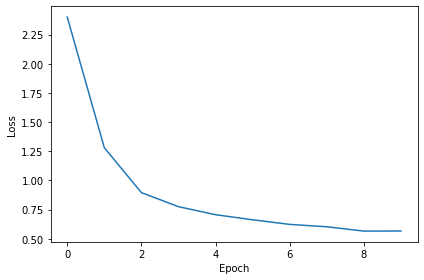

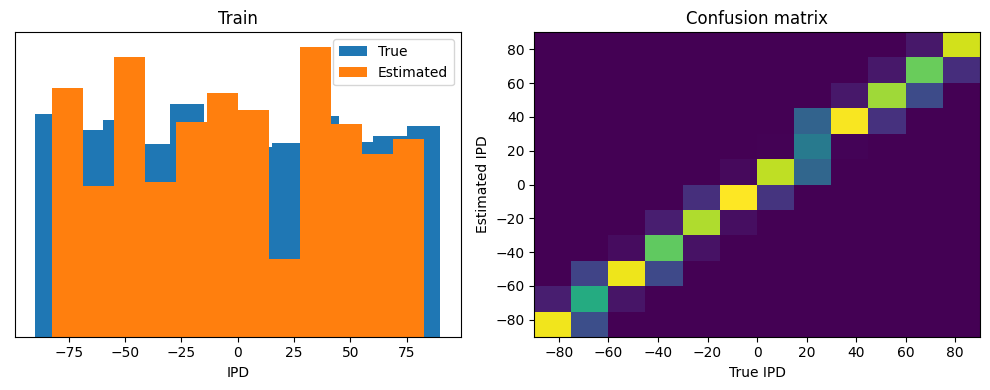

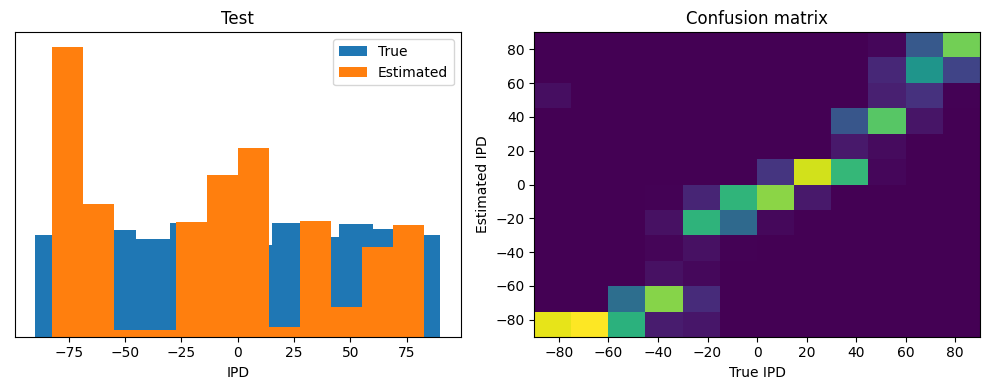

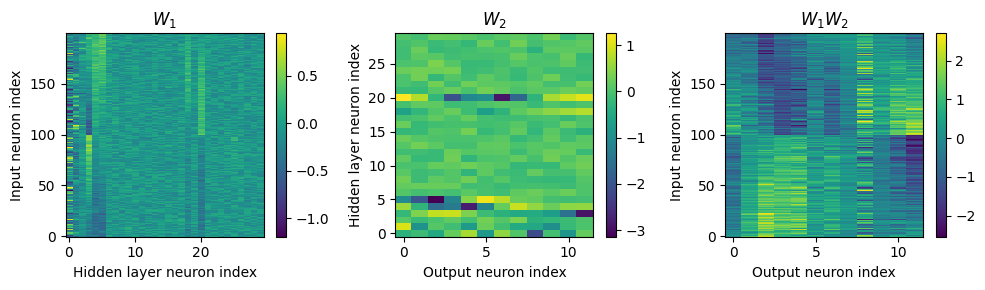

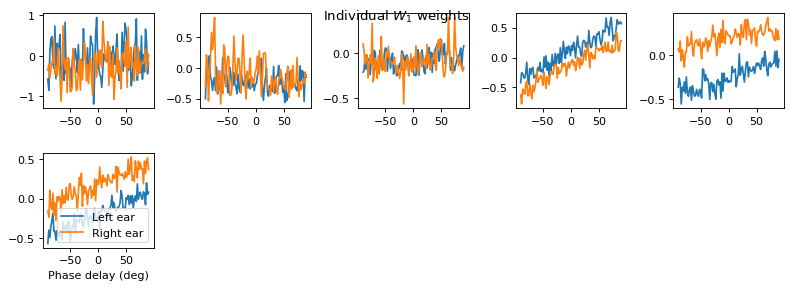

In [19]:
vis(snn_original, model_args={'reset': False})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.92435
Epoch 2: loss=1.16450
Epoch 3: loss=0.90717
Epoch 4: loss=0.76186
Epoch 5: loss=0.65429
Epoch 6: loss=0.57840
Epoch 7: loss=0.50956
Epoch 8: loss=0.46623
Epoch 9: loss=0.42350
Epoch 10: loss=0.39557
Chance accuracy level: 8.3%

Train classifier accuracy: 90.9%
Train absolute error: 4.0 deg

Test classifier accuracy: 86.0%
Test absolute error: 4.2 deg


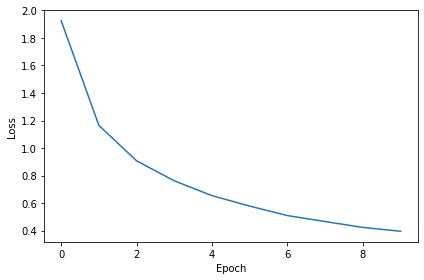

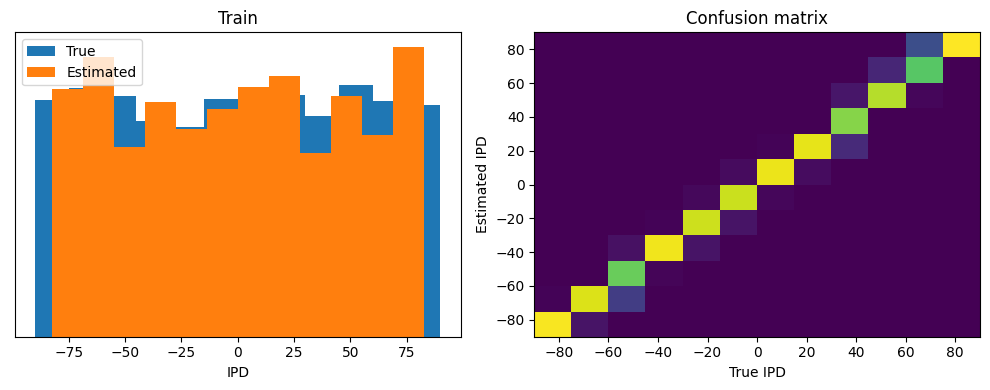

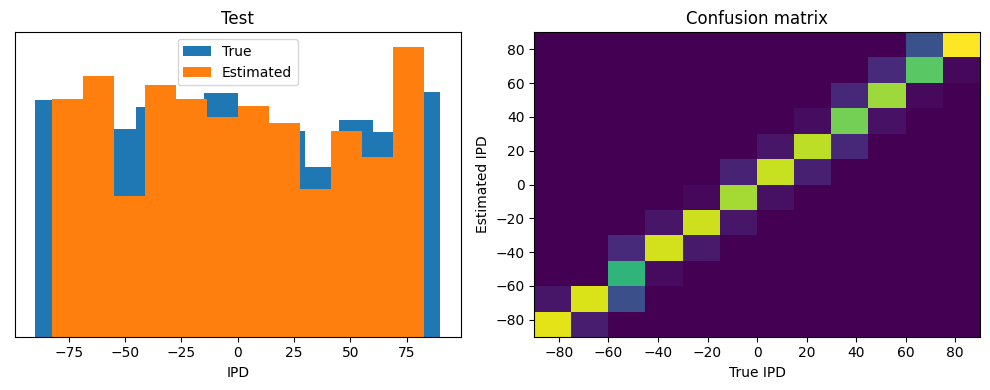

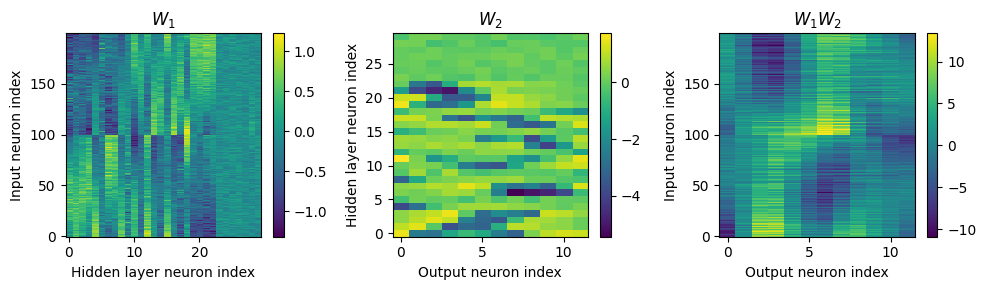

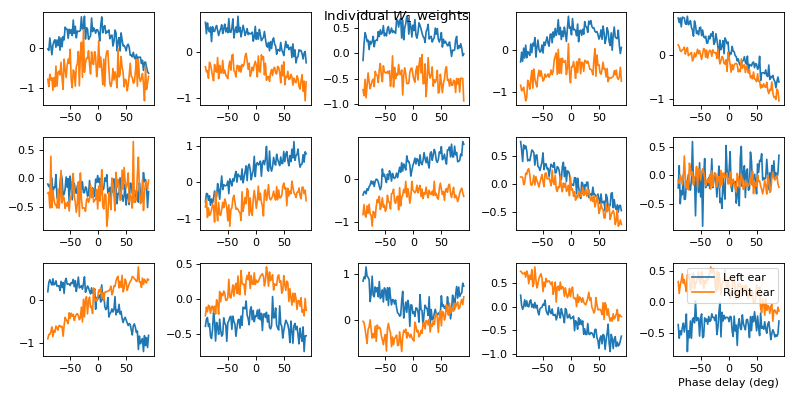

In [16]:
vis(snn_original, model_args={'tau': 2*ms, 'reset': False})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.38518
Epoch 2: loss=1.14402
Epoch 3: loss=0.88273
Epoch 4: loss=0.75445
Epoch 5: loss=0.66793
Epoch 6: loss=0.61421
Epoch 7: loss=0.58513
Epoch 8: loss=0.50360
Epoch 9: loss=0.46970
Epoch 10: loss=0.45387
Chance accuracy level: 8.3%

Train classifier accuracy: 83.0%
Train absolute error: 4.7 deg

Test classifier accuracy: 67.6%
Test absolute error: 6.2 deg


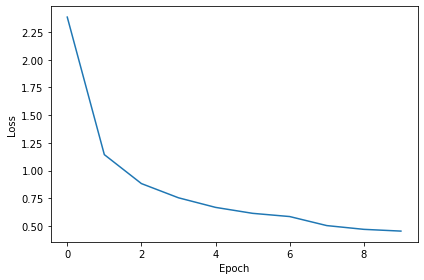

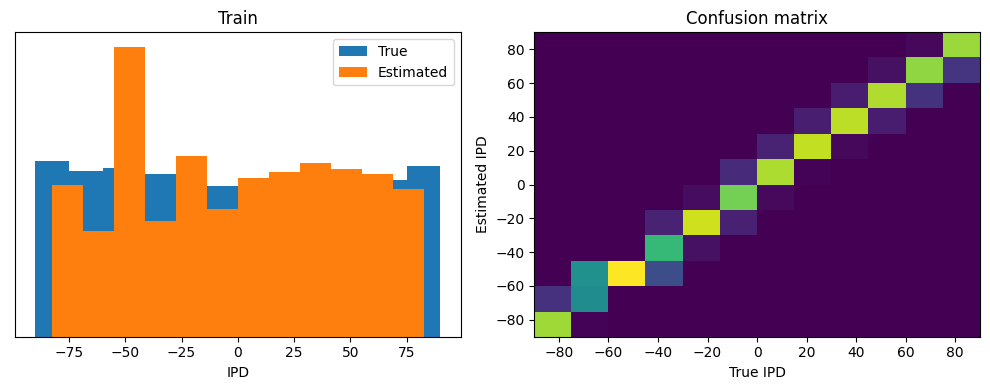

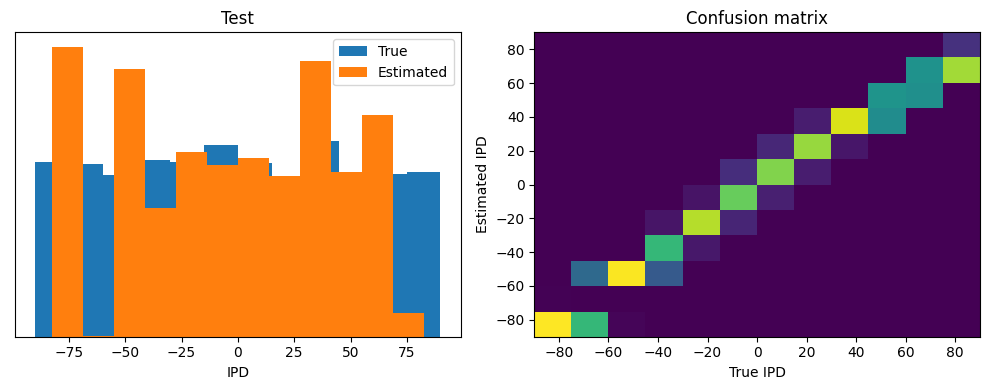

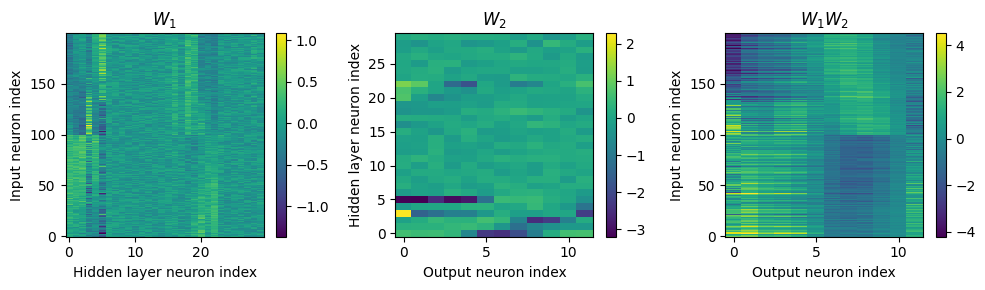

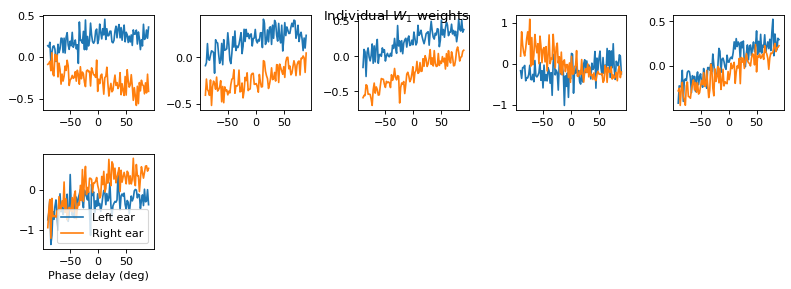

In [ ]:
vis(snn_dth, model_args={'reset': False})

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.92113
Epoch 2: loss=1.13287
Epoch 3: loss=0.85042
Epoch 4: loss=0.71217
Epoch 5: loss=0.62477
Epoch 6: loss=0.56385
Epoch 7: loss=0.50425
Epoch 8: loss=0.46258
Epoch 9: loss=0.42641
Epoch 10: loss=0.40255
Chance accuracy level: 8.3%

Train classifier accuracy: 91.0%
Train absolute error: 4.0 deg

Test classifier accuracy: 87.6%
Test absolute error: 4.2 deg


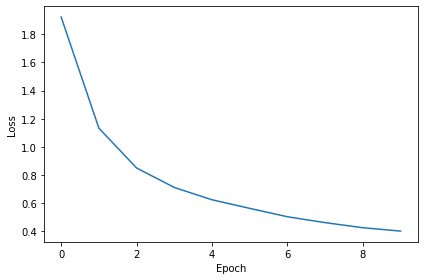

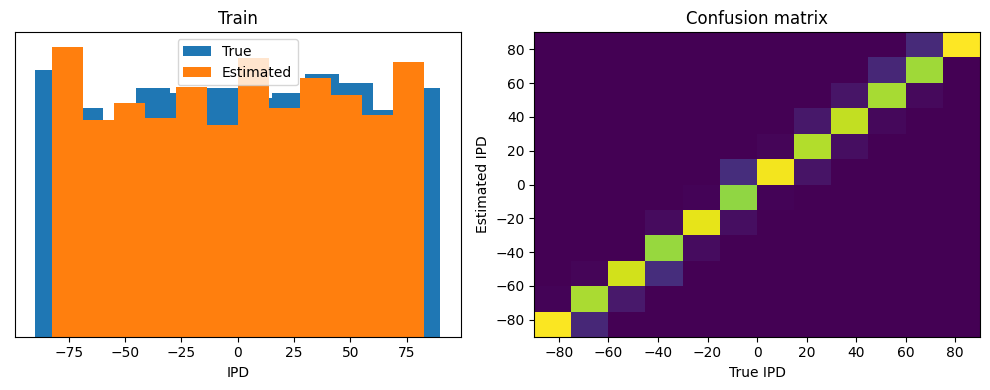

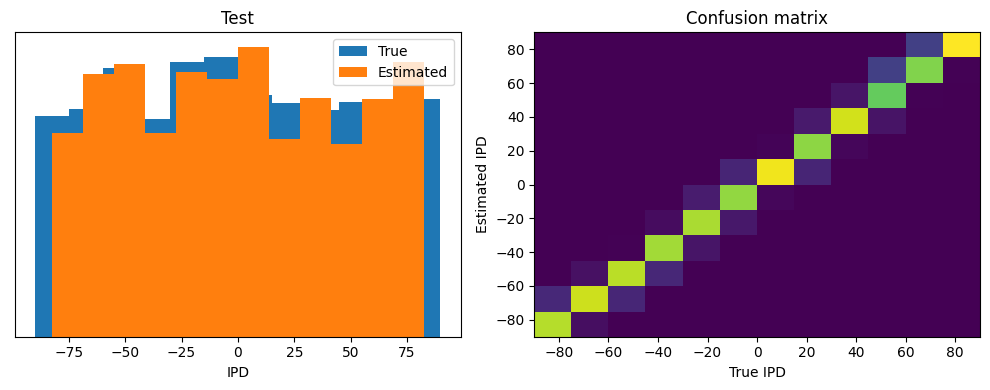

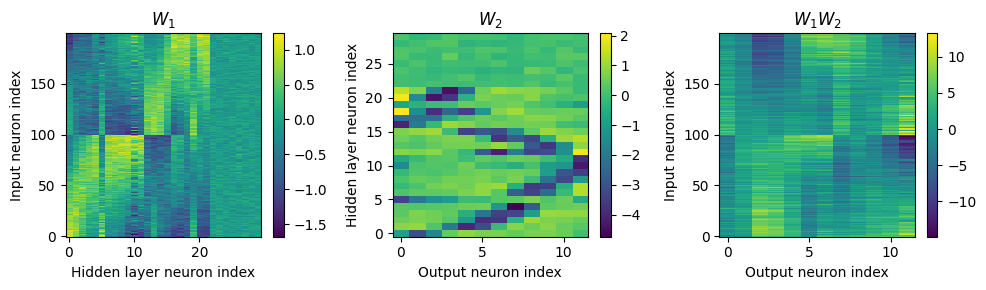

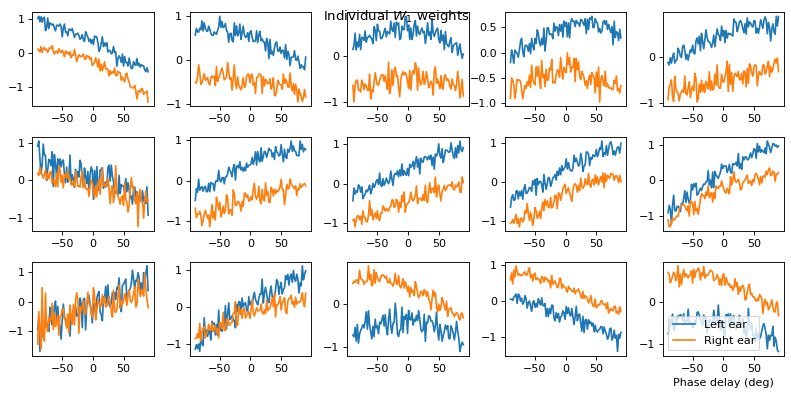

In [ ]:
vis(snn_dth, model_args={'tau': 2*ms, 'tau_t': 2*ms, 'reset': False})